# Creditos

Los datos de la manianera los obtuvimos del grupo @nostrodata
* GitHub : https://github.com/NOSTRODATA/conferencias_matutinas_amlo

# Libreta 1: Obención de datos

## Importaciones
* Importamos la librería pandas para manipular fácimodel1ente los archivos <code>.csv</code>.
* Importamos la librería glob para leer fácimodel1ente los archivos <code>.csv</code>.

In [27]:
# Para libretas 1 y 2
import pandas as pd
import glob
import re
import random as rd
import numpy as np
from nltk.corpus import stopwords
from collections import Counter
import seaborn as sns
from collections import defaultdict

# Para libretas 3
from nltk.lm.preprocessing import padded_everygram_pipeline
from nltk.lm import MLE
from nltk.lm import Laplace
from nltk.lm import  KneserNeyInterpolated

## Limpieza de los datos
En la siguiente linea de código se usa la función <code>glob</code> para generalizar las carpetas del dataset para extraer todos los <code>.csv</code> de el mes de enero.


In [2]:
csv_files = glob.glob('conferenciasMatutinasAmlo/2022/1-2022/enero */mananera_*_01_2022.csv')
# print(csv_files)

Ahora que tenemos las rutas, iteramos sobre ellas y guardamos todos los datos en una lista llamada <code>filelist</code>.


In [3]:
filelist = []
for file in csv_files:
    df = pd.read_csv(file)
    filelist.append(df)

In [4]:
# Numero de manianeras de enero 2022
len(filelist)

17

Observamos uno de los dataframes de la lista.

In [5]:
filelist[2]

,Participante,Texto,Sentimiento,Palabras,Dia,Mes,Anio
0,PRESIDENTE ANDRES MANUEL LOPEZ OBRADOR,Buenos días.,0.0,2,18,1,2022
1,PRESIDENTE ANDRES MANUEL LOPEZ OBRADOR,"Pues vamos a informar, como todos los martes, ...",0.0,52,18,1,2022
2,JORGE ALCOCER VARELA,"Con su permiso, señor presidente.",0.0,5,18,1,2022
3,JORGE ALCOCER VARELA,Muy buenos días a todas y a todos ustedes.,0.0,9,18,1,2022
4,JORGE ALCOCER VARELA,"Como señala el señor presidente, en este momen...",0.0,55,18,1,2022
...,...,...,...,...,...,...,...
353,PRESIDENTE ANDRES MANUEL LOPEZ OBRADOR,Todo esto lo comento porque sí hay toda una ca...,0.0,46,18,1,2022
354,PRESIDENTE ANDRES MANUEL LOPEZ OBRADOR,Nada más porque por respeto no hablo de que en...,0.0,41,18,1,2022
355,PREGUNTA,¿Contra Del Mazo?,0.0,3,18,1,2022
356,PRESIDENTE ANDRES MANUEL LOPEZ OBRADOR,"Y contra otras candidatas, que me enteré que ...",0.0,49,18,1,2022


Ahora limpiamos columas que no nos sirven mediante la función <code>drop()</code> de pandas

Después filtramos los participantes para sólo tener diálogos del presidente.

In [6]:
filteredDf = []
for df in filelist:
    # Eliminamos columnas
    df = df.drop(['Sentimiento', 'Palabras', 'Dia', 'Mes', 'Anio'], axis=1)

    # Filtramos para sólo tener participaciones del presidente
    df = df[df['Participante'] == 'PRESIDENTE ANDRES MANUEL LOPEZ OBRADOR']

    df = df.drop(['Participante'], axis=1)

    # left_aligned_df = df.style.set_properties(**{'text-align': 'left'})
    
    # filteredDf.append(left_aligned_df)
    filteredDf.append(df)


Observamos uno de los dataframes para confirmar que las columnas se eliminaron y sólo hay participaciones del presidente.


In [7]:
filteredDf[0]

,Texto
0,Buenos días.
1,Vamos a iniciar la semana con el quién es quié...
44,Vamos a los videos.
98,Muy bien. Pues vamos adelante. Quedó pendient...
103,"Pues muy bien, hay que esperar a que resuelva..."
...,...
309,"Bueno, vamos a desayunar."
311,Con Beatriz.
313,"Al rato, al rato."
315,"Ah, pero ya tenemos el informe, te lo van a e..."


## Archivo de texto

Ahora que tenemos todos los datos filtrados, los guardaremos en un archivo, alineandolos a la izquierda y que cada oración dicha por AMLO esté en una línea.

In [10]:
# with open("conferencias_matutinas_amlo.txt", "w", encoding='utf-8') as f:

    
#     for i, df in enumerate(filteredDf):

#         # Cambiamos la indexacion para que este corrida
#         inx = range(0,df.shape[0])
#         dfIndex = df.reindex(index=inx) 

#         for j in range(df.shape[0]) :

#             texto_str = str(dfIndex['Texto'][j]).strip()

#             if texto_str == 'nan' :
#                 continue

#             f.write(texto_str + '\n')


Corpus donde cada linea es una oracion

In [16]:
with open("conferencias_matutinas_amlo.txt", "w", encoding='utf-8') as f:

    sentence = str()

    for df in filteredDf:

        for i in range(len(df)) :

            text_str = df['Texto'].iloc[i]

            for word in text_str :
                
                if word == '.' :

                    sentence += word
                    f.write(sentence.strip() + '\n')
                    sentence = str()

                else :

                    sentence += word    


# Libreta 2

## Partimos el corpus en entrenamiento y prueba de forma aleatoria

Primero contaremos el numero de oraciones (lineas) que tiene nuestro corpus.

In [9]:
with open('conferencias_matutinas_amlo.txt', 'r', encoding='utf-8') as f :

    lineCount = 0

    for line in f :

        lineCount += 1

Obtenemos el numero de lineas que tendra el archivo de pruebas y un arreglo con las lineas que iran en dicho archivo.

In [10]:
rd.seed(16) # Semilla 
porcentage = 20
testPart = int(lineCount*porcentage/100)


testLines = []
while len(testLines) != testPart :

    random = rd.randint(0,lineCount-1)
    
    if random not in testLines : # Si el numero random no esta ya en la lista testLines entonces agregalo

        testLines.append(random)

Ahora crearemos dos nuevos archivos, el de entrenamiento y el de prueba.

In [11]:
with open("conferencias_matutinas_amlo.txt", "r", encoding='utf-8') as f :

    with open("train.txt", "w", encoding='utf-8') as train :

        with open("test.txt", "w", encoding='utf-8') as test :

            for i, line in enumerate(f) :

                if i in testLines : # Si la linea i esta en testLines escribelo en el arhivo test

                    test.write(line)

                else : # De lo contrario va en train
                    train.write(line)


Vemos si se hizo bien la separacion.

In [12]:
with open('train.txt', 'r', encoding='utf-8') as f :

    lineCountTrain = 0

    for line in f :

        lineCountTrain += 1

with open('test.txt', 'r', encoding='utf-8') as f :

    lineCountTest = 0

    for line in f :

        lineCountTest += 1

print(lineCount)
print(lineCountTrain)
print(lineCountTest)
print(lineCountTrain + lineCountTest)

3909
3128
781
3909


Tokenizaremos el texto. La tokezinación será por oración que dijo el presidente, y cada oración estará tokenizada por palabra. Quitaremos los signos de puntuación, pero dejaremos los acentos.

Función para quitar los signos de puntación y poner todo en minúsculas, además de poner el texto en una lista.

In [16]:
# def noPuntuacion(text): return re.findall(r'[a-zA-ZñÑáéíóúÁÉÍÓÚüÜ]+', text.lower())

Separaremos cada entrada del presidente en oraciones y creamos una lista de lista con cada oracion tokenizada.

In [17]:
# texto = []
# sentence = str()

# with open("conferencias_matutinas_amlo.txt", "r", encoding='utf-8') as f:

#     for i,line in enumerate(f) :

#         for word in line :

#             if word == '.' :

#                 texto.append(noPuntuacion(sentence))
#                 sentence = str()

#             else :

#                 sentence += word

In [18]:
# def separacionCorpus(text, porcentage, seed) :

#     rd.seed(seed)

#     textTrain = text.copy()
#     textTest = []
#     testPart = int(len(textTrain)*porcentage/100)

#     for i in range(testPart) :

#         index = rd.randint(0,len(textTrain)-1) 
#         textTest.append(textTrain[index])
#         del textTrain[index]

#     return textTrain, textTest

# ANÁLISIS EXPLORATORIO

In [13]:
#CREAR DATAFRAME A PARTIR DEL TRAIN.TXT
columns=["sentences"]
data = pd.read_csv("train.txt", delimiter="\t", header=None, names=columns)
print(data)

                                              sentences
0         Entonces, vamos a darle la palabra a Ricardo.
1                                   Vamos a los videos.
2                                  Pues vamos adelante.
3                     Quedó pendiente Eduardo Esquivel.
4     Pues muy bien, hay que esperar a que resuelva ...
...                                                 ...
3123  Y, en efecto, hoy es un aniversario más de los...
3124                          Hay crónicas muy fuertes.
3125  Después de la represión subían los cuerpos de ...
3126  Ahí estuvo reprimiendo a los mayas Victoriano ...
3127  Y, fíjense, Quintana Roo, que era una cárcel y...

[3128 rows x 1 columns]


<AxesSubplot:>

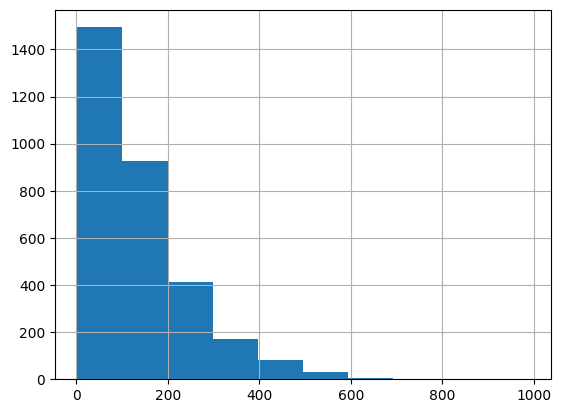

In [17]:
# HISTOGRAMA DE CANTIDAD DE CARACTERES POR ORACIÓN
data['sentences'].str.len().hist()

Explicación: Las oraciones están entre 0 y 600 caracteres, siendo la mayoría entre 0 y 100.

<AxesSubplot:>

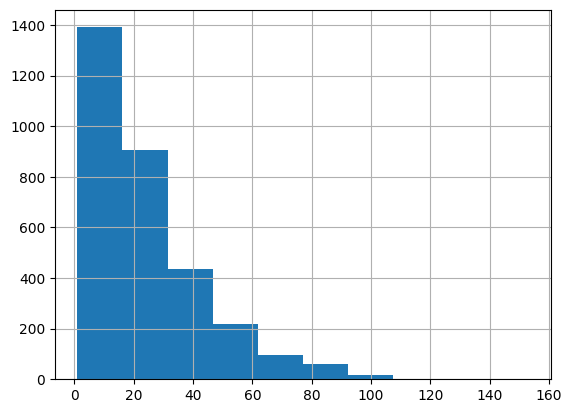

In [18]:
# HISTOGRAMA DE CANTIDAD DE PALABRAS POR ORACIÓN
data['sentences'].str.split().map(lambda x: len(x)).hist()

<AxesSubplot:>

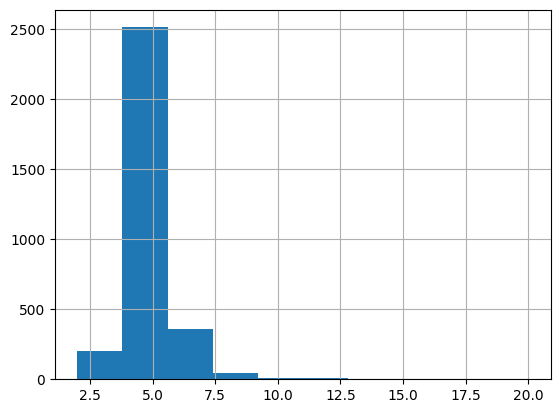

In [21]:
# HISTOGRAMA DE LA LONGITUD PROMEDIO DE PALABRAS
data['sentences'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist()

In [24]:
# IDENTIFICAR STOPWORDS EN EL TEXTO:

stopwords_es = stopwords.words('spanish')

corpus=[]
new = data['sentences'].str.split()
new = new.values.tolist()
corpus=[word for i in new for word in i]

dic=defaultdict(int)
for word in corpus:
    if word in stopwords_es:
        dic[word]+=1

print(dic)

defaultdict(<class 'int'>, {'a': 2216, 'la': 2053, 'los': 1348, 'muy': 273, 'hay': 361, 'que': 3127, 'el': 1816, 'de': 3503, 'ellos': 69, 'su': 140, 'también': 204, 'tiene': 183, 'es': 1215, 'no': 1333, 'hemos': 60, 'tenido': 11, 'durante': 42, 'en': 1531, 'cuando': 141, 'se': 1350, 'como': 314, 'del': 540, 'estos': 67, 'era': 167, 'más': 325, 'sí': 102, 'y': 1749, 'lo': 920, 'esto': 147, 'había': 71, 'para': 602, 'las': 548, 'nos': 267, 'sería': 15, 'un': 689, 'esté': 19, 'este': 146, 'están': 179, 'todo': 225, 'otra': 39, 'son': 217, 'una': 499, 'ya': 529, 'porque': 563, 'o': 308, 'tenían': 23, 'sobre': 146, 'al': 289, 'les': 170, 'ha': 99, 'sin': 74, 'haya': 52, 'sea': 30, 'esa': 110, 'todos': 183, 'otras': 48, 'algo': 43, 'me': 133, 'está': 275, 'muchos': 33, 'entre': 38, 'te': 40, 'tenía': 26, 'sus': 79, 'por': 499, 'estamos': 182, 'pero': 417, 'mucho': 108, 'con': 615, 'nuestros': 33, 'tengo': 64, 'algunos': 16, 'he': 31, 'eso': 329, 'esta': 101, 'yo': 157, 'tienen': 97, 'hasta':

11038


<Axes: >

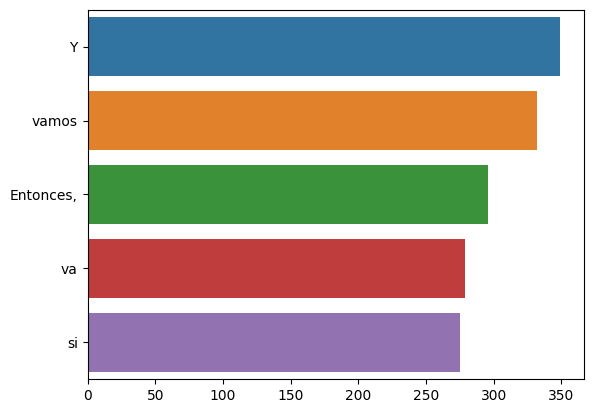

In [22]:
#IDENTIFICAR NO STOPWORDS EN EL TEXTO


counter=Counter(corpus)
most=counter.most_common()
print(len(counter))
x, y= [], []
for word,count in most[:40]:
    if (word not in stopwords_es):
        x.append(word)
        y.append(count)

sns.barplot(x=y,y=x)

# Libreta 3

## Entrenamiento del modelo

In [ ]:
textoPruebas = [["Ya", "nada", "más", "es", "como", "lo", "de", "Oaxaca"],
                ["como", "lo", "de", "los", "caminos", "de", "Oaxaca"], 
                ["vamos", "a", "buscar", "el", "mecanismo", "entregarle", "los", "fondos"],
                ["y", "que", "decidan", "democráticamente", "qué", "caminos", "construir"]]

Ya que tenemos una lista de listas con todas las palabras tokenizadas, debemos de crear un n-grama de entrenamiento y el vocabulario.

- Creamos el n-grama de entranamiento

    - Primero acolchonamos las oraciones. Esto es poner uno o mas simbolos como inicio (\<s>) y otro como fin (<\s>) de oracion. Este acolchonamiento en la paqueteria de nltk es simetrico, esto es pone el mismo numero de simbolos al inicio como al final. La salida sera una lista de listas pero acolchonada
    - Segundo convertir a un n-grama. Con la salida del paso anterior crearemos nuestro unigrama, bigrama, trigrama, etc. Para hacer el modelo mas robusto se pueden hacer n,(n-1),..,.1-gramas, esto es, si tenemos que el n-grama maximo que queremos es un trigrama, tambien podemos hacer bigramas y unigramas. La salida sera una lista de lista con el/los n-grama(s).

- Creamos el vocabulario

    - A la lista de listas acolchonada que hicimos en la creacion del n-grama simplemente la aplanamos, esto es, pasamos de una lista de listas a solo una lista donde tendremos todas las palabras de nuestro texto tokenizadas. La salida sera una lista acolchonada con las palabras tokenizadas.

Para suerte de nosotros la paqueteria nltk ya tiene una funcion para realizar todo esto : 

**padded_everygram_pipeline(order, text)**

Esta funcion recibe dos parametros, *order* y *text*. 
- Text es la lista de listas tokenizadas.
- Order es el order del n-grama maximo, ya que esta funcion nos devuelve n,(n-1),..,.1-gramas. Ademas es el numero de acolchonamiento que tendran los n-gramas.


### Modelo 1 : Unigramas

Dicho lo anterior entonces para un Unigrama *order = 1*

In [ ]:
nModel1 = 1
trainDataModel1, paddedVocabModel1 = padded_everygram_pipeline(nModel1, textoPruebas)

Para entrenar el modelo usaremos el estimador maximo de posibilidad, MLE por sus siglas en ingles (Maximum Likelihood Estimator).

In [ ]:
model1 = MLE(nModel1) # Donde 1 dice el n-grama maximo 

Esto crea un vocabulario vacio.

In [ ]:
len(model1.vocab)

0

Ahora llenamos el modelo. La longitud del vocabulario seria la cantidad de palabras sin repetir mas el token \<UNK>, el cual es el token para identificar las palabras desconocidas.

In [ ]:
model1.fit(trainDataModel1, paddedVocabModel1)
print(model1.vocab)
print(len(model1.vocab))

<Vocabulary with cutoff=1 unk_label='<UNK>' and 24 items>
24


Ya con nuestro modelo entranado podremos ver cuales palabras de un texto estan en nuestro vocabulario.

In [ ]:
print(model1.vocab.lookup(textoPruebas[0]))

print(model1.vocab.lookup(["serendipia", "snickers", "Universo", "fondos"]))

('Ya', 'nada', 'más', 'es', 'como', 'lo', 'de', 'Oaxaca')
('<UNK>', '<UNK>', '<UNK>', 'fondos')


Los modelos de n-gramas al final se reduce a contar los n-gramas del corpus de entranamiento. Para saber que tan probable son las palabras en un contexto particular.

In [ ]:
print("Numero de veces que aparece el unigrama 'los' en el texto : " + str(model1.counts['los']))
print("Numero de veces que aparece el unigrama 'Oaxaca' en el texto : " + str(model1.counts['Oaxaca']))

Numero de veces que aparece el unigrama 'los' en el texto : 2
Numero de veces que aparece el unigrama 'Oaxaca' en el texto : 2


Ademas de contar el numero de veces que aparece el unigrama podemos obtener la frecuencia relativa y el logaritmo de la frecuencia relativa, esta ultima es importante cuando tenemos un corpus muy grande ya que la frecuencia se vuelve demasiado pequenia y podemos caer en underflow.

In [ ]:
print("Frecuencia relativa de la palabra 'el' :" + str(model1.score('el')))
print("Logaritmo de la frecuencia relativa de la palabra 'el' :" + str(model1.logscore('el')))
print("Frecuencia relativa de una palabra fuera de vocabulario :" + str(model1.score('rl')))
print("Logaritmo de la frecuencia relativa de una palabra fuera de vocabulario :" + str(model1.logscore('rl')))

Frecuencia relativa de la palabra 'el' :0.03333333333333333
Logaritmo de la frecuencia relativa de la palabra 'el' :-4.906890595608519
Frecuencia relativa de una palabra fuera de vocabulario :0.0
Logaritmo de la frecuencia relativa de una palabra fuera de vocabulario :-inf


Como es un unigrama no podemos calcular la posibilidad de que una palabra prosiga a otra, como se ve en el siguiente ejemplo.

In [ ]:
print(model1.score("los", ["fondos"]))

0


### Modelo 2 : Bigramas

Para este modelo hacemos practicamente lo mismo que el modelo1, ahora el n-grama maximo sera 2.

In [ ]:
nModel2 = 2
trainDataModel2, paddedVocabModel2 = padded_everygram_pipeline(nModel2, textoPruebas)
model2 = MLE(nModel2)
model2.fit(trainDataModel2, paddedVocabModel2)
print(model2.vocab)
print(len(model2.vocab))

<Vocabulary with cutoff=1 unk_label='<UNK>' and 26 items>
26


Ahora podremos buscar tanto unigramas como bigramas.

In [ ]:
print("Numero de veces que aparece el unigrama 'los' en el texto : " + str(model2.counts['los']))
print("Numero de veces que aparece el unigrama 'Oaxaca' en el texto : " + str(model2.counts['Oaxaca']))
print("Numero de veces que aparece el bigrama 'los fondos' en el texto : " + str(model2.counts[['los']]['fondos']))
print("Numero de veces que aparece el bigrama 'de Oaxaca' en el texto : " + str(model2.counts[['de']]['Oaxaca']))

Numero de veces que aparece el unigrama 'los' en el texto : 2
Numero de veces que aparece el unigrama 'Oaxaca' en el texto : 2
Numero de veces que aparece el bigrama 'los fondos' en el texto : 1
Numero de veces que aparece el bigrama 'de Oaxaca' en el texto : 2


Con bigramos ya podemos calcular la posibilidad de una palabra sea precedida de otra.

In [ ]:
print("Posibilidad de 'los' de preceder de 'fondos' : " + str(model2.score("fondos", ["los"])))
print("Posibilidad de 'fondos' de preceder de 'los' : " + str(model2.score("los", ["fondos"])))
print("Logaritmo de la posibilidad de 'los' de preceder de 'fondos' : " + str(model2.logscore("fondos", ["los"])))
print("Logaritmo de la posibilidad de 'fondos' de preceder de 'los' : " + str(model2.logscore("los", ["fondos"])))

Posibilidad de 'los' de preceder de 'fondos' : 0.5
Posibilidad de 'fondos' de preceder de 'los' : 0.0
Logaritmo de la posibilidad de 'los' de preceder de 'fondos' : -1.0
Logaritmo de la posibilidad de 'fondos' de preceder de 'los' : -inf


Ya que tenemos nuestro modelo entrenado con un corpus especifico que pasara al enfrentarlo con situaciones reales?. Nuestro corpus no tiene todas las palabras y suponiendo que si las tiene, el lenguaje evoluciona creando nuevas palabras, entonces cuando nuestro modelo de lenguaje se encuentre con estas nuevas palabras al estimar su posibilidad de preceder o de seguir en una oracion obtendremos cero, lo cual es muy problematico ya que la posibilidad de una oracion se calcula como el producto de las posibilidades de cada palabras en ella.

En el modelo 1 y 2 usamos el estimador de maxima posibilidad, que esta dado por la siguiente ecuacion :

$
P(w_n | w_{n-N+1}^{n-1}) = \frac{C(w_{n-N+1}^{n-1}W_n)}{C(w_{n-N+1}^{n-1})} 
$

Donde N es el tipo de N-grama; $N=2$ es un bigrama, $w_1^n$ es la secuencia de palabras; $w_1^n = w_1w_2 \cdots w_n$, C(s) es la frecuencia que aparece la oracion s en el corpus de entrenamiento. 

Entonces para evitar obtener $P(w|s) = 0$ cuando $w$ es una palabra nueva usamos una tecnica de suavizado. Existe varias de estas tecnicas, por ejemplo :

1. Suavizado de Laplace
2. suavizado de Good-Turing
3. Interpolacion simple de Jelinek-Mercer 
4. Discontinuidad absoluta
5. Suavizado de Kneser-Ney
6. Suavizado de Katz


### Modelo 3 : Suavizado de Laplace

El suavizado de Laplace basicamente solo aniade un 1 a todas frecuencias de aparicion de una oracion para eliminar los 0's. Cambiando el calculo de la posibilidad a la siguiente ecuacion :

$
P(w_n | w_{n-N+1}^{n-1}) = \frac{C(w_{n-N+1}^{n-1}W_n) + 1}{C(w_{n-N+1}^{n-1}) + V} 
$

Donde V es el tamanio del vocabulario.

Para comparar con el modelo MLE usaremos el mismo tratamiento para obtener los datos de entrenamiento y vocabulario.

In [ ]:
nModel3 = 2
trainDataModel3, paddedVocabModel3 = padded_everygram_pipeline(nModel3, textoPruebas)
model3 = Laplace(nModel3)
model3.fit(trainDataModel3, paddedVocabModel3)
print(model3.vocab)
print(len(model3.vocab))

<Vocabulary with cutoff=1 unk_label='<UNK>' and 26 items>
26


In [ ]:
print("P(los fondos) usando MLE : " + str(model2.score("fondos", ["los"])))
print("P(los fondos) usando Laplace : " + str(model3.score("fondos", ["los"])))
print("P(fondos los) usando MLE : " + str(model2.score("los", ["fondos"])))
print("P(fondos los) usando Laplace : " + str(model3.score("los", ["fondos"])))

P(los fondos) usando MLE : 0.5
P(los fondos) usando Laplace : 0.07142857142857142
P(fondos los) usando MLE : 0.0
P(fondos los) usando Laplace : 0.037037037037037035


Donde vemos como la posibilidad se hace diferente de cero con el suavizado de Laplace.

### Modelo 4 : Escoger un suavizado de la libreria

Escogeremos el suavizado de Kneser-Ney. De igual manera el vocabulario y datos de entrenamiento se obtendran como en los modelos anteriores para poderlos comparar.

Esta suavizado esta dado por la siguiente ecuacion :


$P(w_i | w_{i-1}) = 
    \left\lbrace\begin{array}{c} 
        \frac{max \{C(w_{i-1}w_i) - D,0\}}{C(w_{i-1})} \hspace{0.5cm} \text{si} \hspace{0.5cm} C(w_{i-1}w_i) > 0  \\
        \alpha(w_{i-1})P(w_i) \hspace{0.5cm} \text{si} \hspace{0.5cm} \text{de otra manera}
    \end{array}\right.
$

Con

$
P(w_i) = \frac{C(\bullet w_i)}{\sum_{ w_i}C(\bullet w_i)}
$

Y $C(\bullet w_i)$ es el numero de palabras unicas que preceden $w_i$. Por otro lado $\alpha(w_{i-1})$ es elegido para hacer la suma de la distribucion igual a 1 :

$
\alpha(w_{i-1}) = \frac{1 - \sum_{w_i:C(w_{i_1}w_i)>0}\frac{max\{C(w_{i-1}w_i) - D,0\}}{C(w_{i-1})}}{1 - \sum_{w_i:C(w_{i_1}w_i)>0}P(w_i)}
$

En la ecuacion del suavizado tenemos $D$ que es un parametro que le da a la funcion, este se llama descuento y toma valores en el intervalo $[0,1]$.


In [ ]:
nModel4 = 2
D = 0.0
trainDataModel4, paddedVocabModel4 = padded_everygram_pipeline(nModel4, textoPruebas)
model4 = KneserNeyInterpolated(nModel4, D)
model4.fit(trainDataModel4, paddedVocabModel4)
print(model4.vocab)
print(len(model4.vocab))

<Vocabulary with cutoff=1 unk_label='<UNK>' and 26 items>
26


In [ ]:
print("P(los fondos) usando MLE : " + str(model2.score("fondos", ["los"])))
print("P(los fondos) usando Laplace : " + str(model3.score("fondos", ["los"])))
print("P(los fondos) usando Kneser-Ney : " + str(model4.score("fondos", ["los"])))
print("P(fondos los) usando MLE : " + str(model2.score("los", ["fondos"])))
print("P(fondos los) usando Laplace : " + str(model3.score("los", ["fondos"])))
print("P(fondos los) usando Kneser-Ney : " + str(model4.score("los", ["fondos"])))

P(los fondos) usando MLE : 0.5
P(los fondos) usando Laplace : 0.07142857142857142
P(los fondos) usando Kneser-Ney : 0.5
P(fondos los) usando MLE : 0.0
P(fondos los) usando Laplace : 0.037037037037037035
P(fondos los) usando Kneser-Ney : 0.0


De igual manera que con el suavizado de Laplace, eliminamos la posibilidad cero. Pero jugando con el valor de $D$ descubrimos que si $D=0$ nos vuelven los mismos resultados que con el modelo MLE. Ademas entre mas disminuya $D$ la posibilidad de una oracion que si estaba en el corpus de entrenamiento aumenta.

## Evaluacion intrinseca de modelos

## Generacion de texto

## Conclusiones